<a href="https://colab.research.google.com/github/hlakisto/PorfolioProjects/blob/main/Creditworthiness_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf




# Predicting creditworthiness 

The following dataset (https://www.kaggle.com/code/ppb00x/credit-risk-classification) will be used in multiple linear regression to predict creditworthiness of customers.

In [4]:
df1 = pd.read_csv('credit_customers.csv')
df1.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [5]:
df1['class'].unique()

array(['good', 'bad'], dtype=object)

Transforming the dataset to numeric data type.

In [6]:

df = df1

for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name] = df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes
    



In [7]:
df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,6.0,1,6,1169.0,4,3,4.0,3,2,4.0,3,67.0,1,1,2.0,1,1.0,1,1,1
1,0,48.0,3,6,5951.0,2,0,2.0,0,2,2.0,3,22.0,1,1,1.0,1,1.0,0,1,0
2,3,12.0,1,2,2096.0,2,1,2.0,3,2,3.0,3,49.0,1,1,1.0,3,2.0,0,1,1
3,1,42.0,3,3,7882.0,2,1,2.0,3,1,4.0,1,45.0,1,0,1.0,1,2.0,0,1,1
4,1,24.0,2,4,4870.0,2,0,3.0,3,2,4.0,2,53.0,1,0,2.0,1,2.0,0,1,0
5,3,36.0,3,2,9055.0,4,0,2.0,3,2,4.0,2,35.0,1,0,1.0,3,2.0,1,1,1
6,3,24.0,3,3,2835.0,1,3,3.0,3,2,4.0,1,53.0,1,1,1.0,1,1.0,0,1,1
7,0,36.0,3,9,6948.0,2,0,2.0,3,2,2.0,0,35.0,1,2,1.0,0,1.0,1,1,1
8,3,12.0,3,6,3059.0,3,1,2.0,1,2,4.0,3,61.0,1,1,1.0,3,1.0,0,1,1
9,0,30.0,1,4,5234.0,2,4,4.0,2,2,2.0,0,28.0,1,1,2.0,0,1.0,0,1,0


In [8]:
df.dtypes

checking_status              int8
duration                  float64
credit_history               int8
purpose                      int8
credit_amount             float64
savings_status               int8
employment                   int8
installment_commitment    float64
personal_status              int8
other_parties                int8
residence_since           float64
property_magnitude           int8
age                       float64
other_payment_plans          int8
housing                      int8
existing_credits          float64
job                          int8
num_dependents            float64
own_telephone                int8
foreign_worker               int8
class                        int8
dtype: object

In [9]:
cols = ['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class']

In [10]:
# Transoform integer datatype to float.

for dt in df[cols]:
  if df[dt].dtype == 'int8':
    df[dt]=df[dt].astype(float)



In [11]:
df.dtypes

checking_status           float64
duration                  float64
credit_history            float64
purpose                   float64
credit_amount             float64
savings_status            float64
employment                float64
installment_commitment    float64
personal_status           float64
other_parties             float64
residence_since           float64
property_magnitude        float64
age                       float64
other_payment_plans       float64
housing                   float64
existing_credits          float64
job                       float64
num_dependents            float64
own_telephone             float64
foreign_worker            float64
class                     float64
dtype: object

In [12]:
df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1.0,6.0,1.0,6.0,1169.0,4.0,3.0,4.0,3.0,2.0,4.0,3.0,67.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
1,0.0,48.0,3.0,6.0,5951.0,2.0,0.0,2.0,0.0,2.0,2.0,3.0,22.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,3.0,12.0,1.0,2.0,2096.0,2.0,1.0,2.0,3.0,2.0,3.0,3.0,49.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,1.0
3,1.0,42.0,3.0,3.0,7882.0,2.0,1.0,2.0,3.0,1.0,4.0,1.0,45.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0
4,1.0,24.0,2.0,4.0,4870.0,2.0,0.0,3.0,3.0,2.0,4.0,2.0,53.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0
5,3.0,36.0,3.0,2.0,9055.0,4.0,0.0,2.0,3.0,2.0,4.0,2.0,35.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0
6,3.0,24.0,3.0,3.0,2835.0,1.0,3.0,3.0,3.0,2.0,4.0,1.0,53.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
7,0.0,36.0,3.0,9.0,6948.0,2.0,0.0,2.0,3.0,2.0,2.0,0.0,35.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0
8,3.0,12.0,3.0,6.0,3059.0,3.0,1.0,2.0,1.0,2.0,4.0,3.0,61.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0
9,0.0,30.0,1.0,4.0,5234.0,2.0,4.0,4.0,2.0,2.0,2.0,0.0,28.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0


In [13]:
# Since class column will be the label it will remain as integer.

df['class'] = df['class'].astype(int)

In [14]:
df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1.0,6.0,1.0,6.0,1169.0,4.0,3.0,4.0,3.0,2.0,4.0,3.0,67.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1
1,0.0,48.0,3.0,6.0,5951.0,2.0,0.0,2.0,0.0,2.0,2.0,3.0,22.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0
2,3.0,12.0,1.0,2.0,2096.0,2.0,1.0,2.0,3.0,2.0,3.0,3.0,49.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,1
3,1.0,42.0,3.0,3.0,7882.0,2.0,1.0,2.0,3.0,1.0,4.0,1.0,45.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,1
4,1.0,24.0,2.0,4.0,4870.0,2.0,0.0,3.0,3.0,2.0,4.0,2.0,53.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,0
5,3.0,36.0,3.0,2.0,9055.0,4.0,0.0,2.0,3.0,2.0,4.0,2.0,35.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,1
6,3.0,24.0,3.0,3.0,2835.0,1.0,3.0,3.0,3.0,2.0,4.0,1.0,53.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1
7,0.0,36.0,3.0,9.0,6948.0,2.0,0.0,2.0,3.0,2.0,2.0,0.0,35.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1
8,3.0,12.0,3.0,6.0,3059.0,3.0,1.0,2.0,1.0,2.0,4.0,3.0,61.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1
9,0.0,30.0,1.0,4.0,5234.0,2.0,4.0,4.0,2.0,2.0,2.0,0.0,28.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0


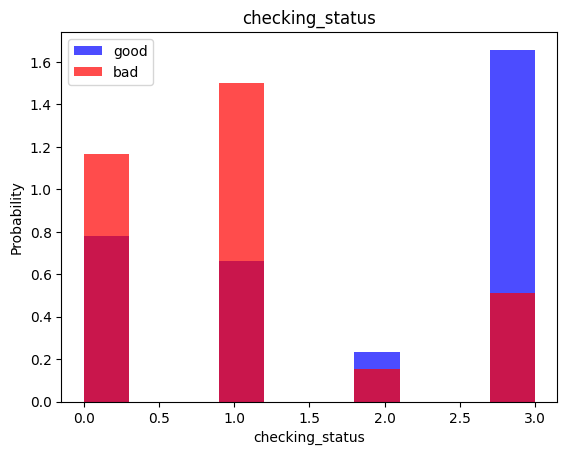

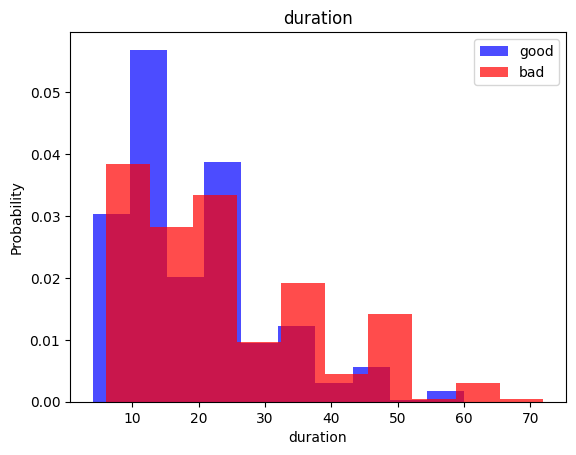

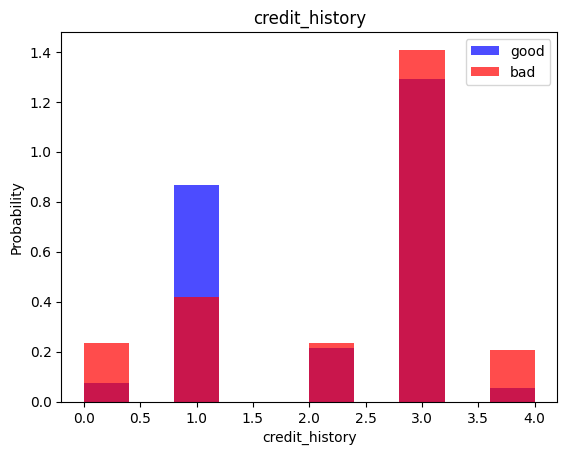

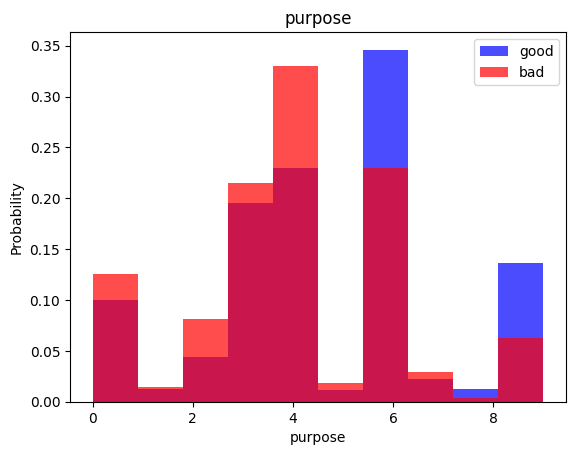

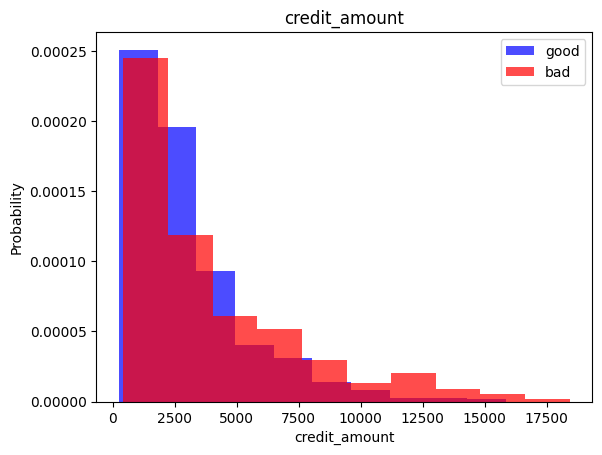

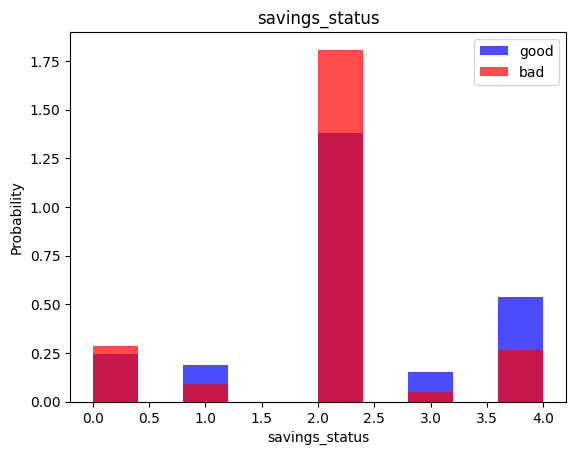

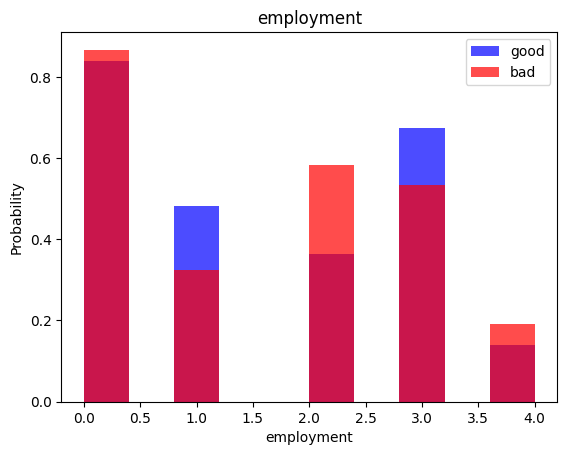

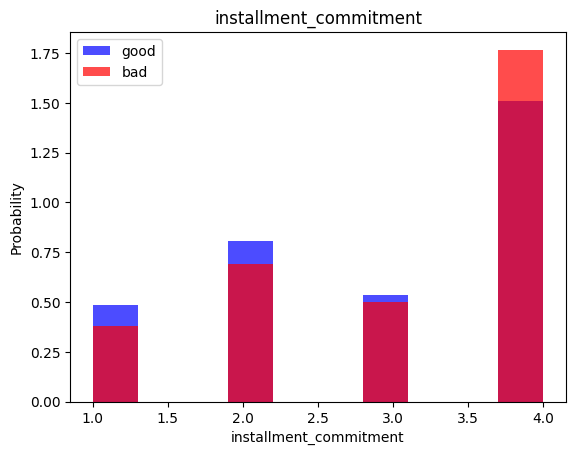

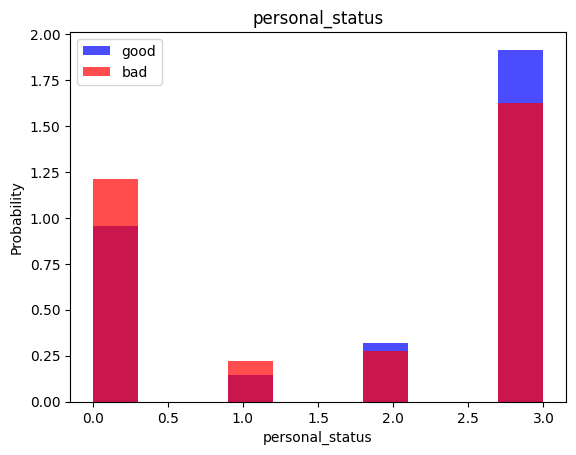

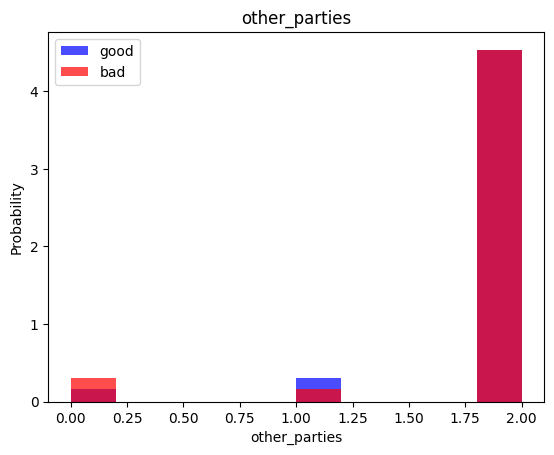

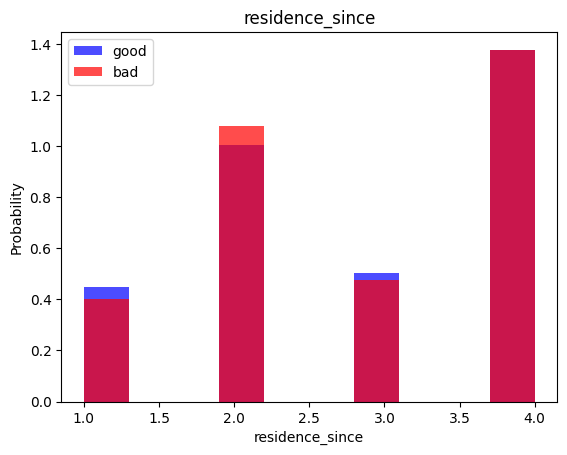

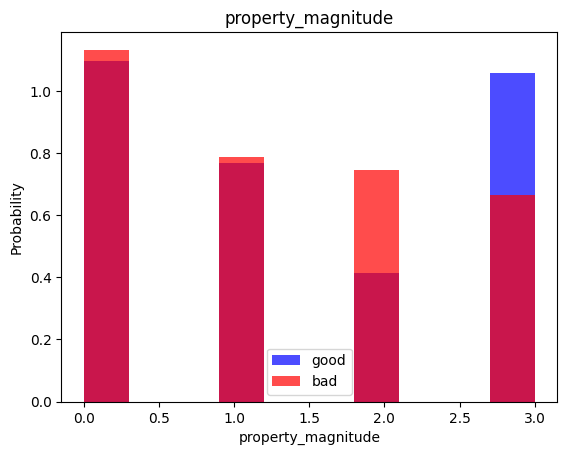

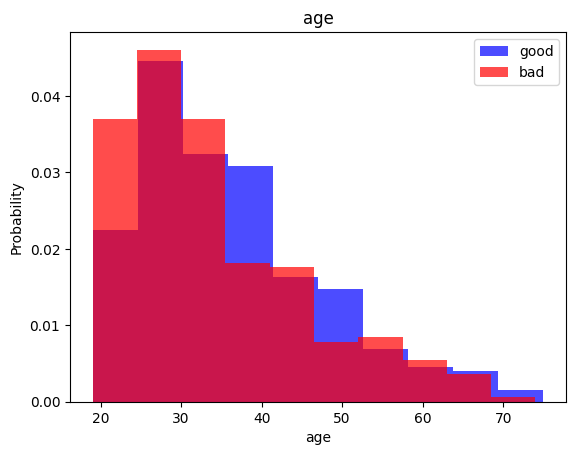

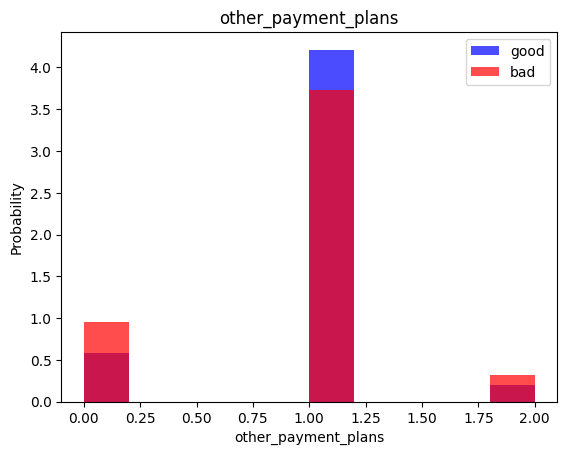

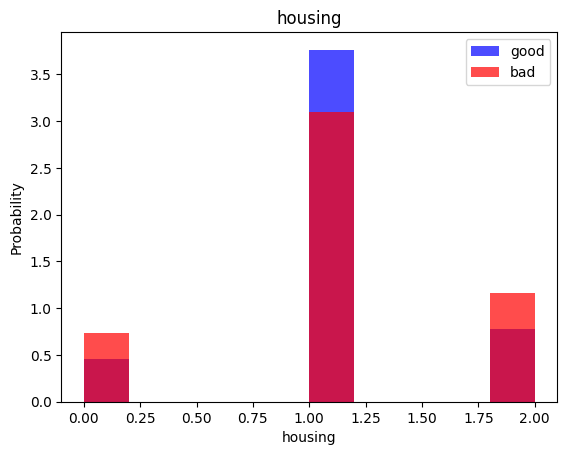

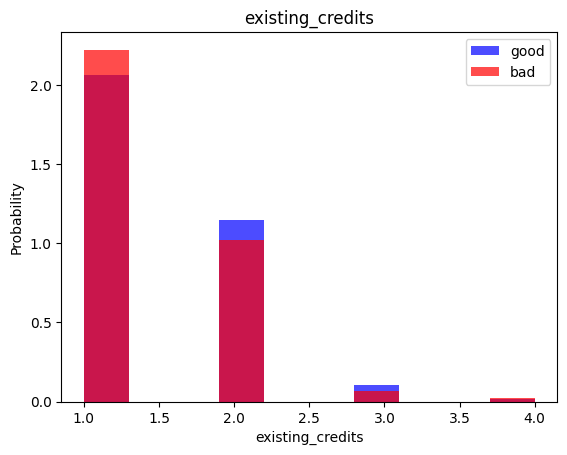

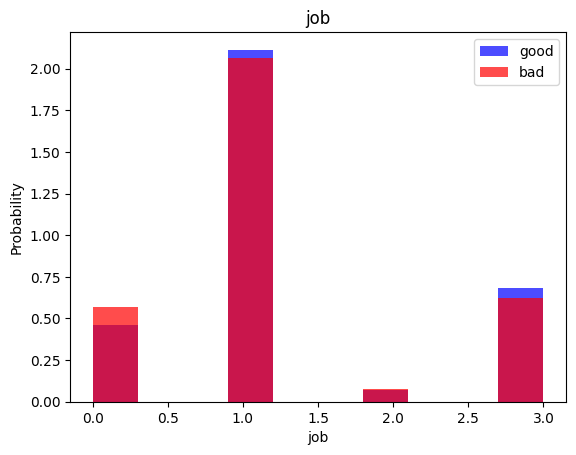

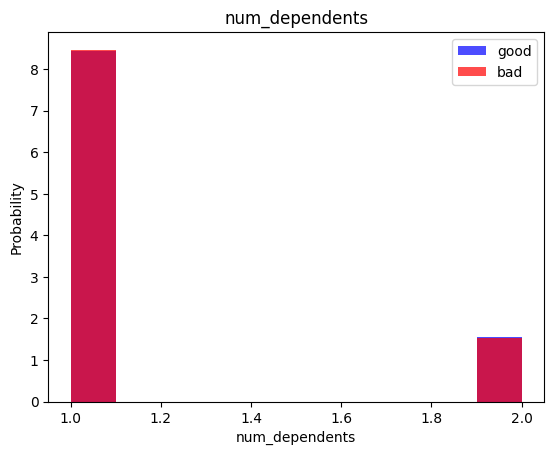

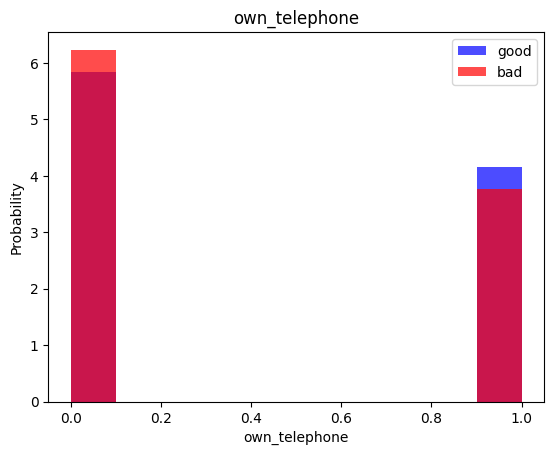

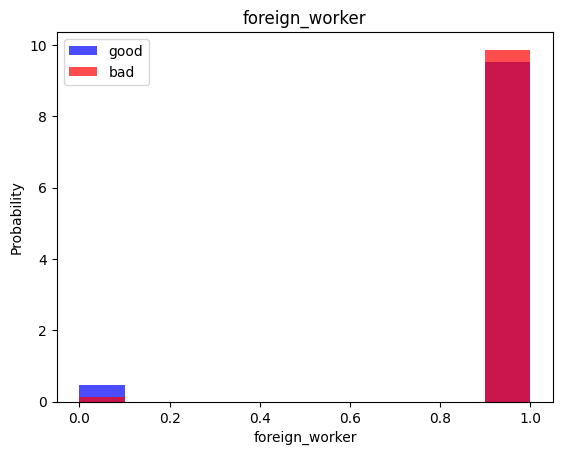

In [15]:
# Analyzing the relationships between features and labels in the data.

for label in cols[:-1]:
  plt.hist(df[df['class']==1][label], color='blue', label='good',alpha=0.7, density=True) # Density normalizes the distributions
  plt.hist(df[df['class']==0][label], color='red', label='bad',alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()

Train and validation datasets

In [17]:

dftrain, dfeval = np.split(df.sample(frac=1),[int(0.8*len(df))])

y_train = dftrain.pop('class')
y_eval = dfeval.pop('class')



In [18]:
dftrain.head(2)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
438,1.0,42.0,1.0,7.0,3394.0,2.0,4.0,4.0,3.0,0.0,4.0,0.0,65.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0
554,0.0,9.0,3.0,2.0,1199.0,2.0,1.0,4.0,0.0,2.0,4.0,1.0,67.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0


In [19]:
df.describe()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.582000,20.903000,2.219000,4.484000,3271.258000,2.1450,1.525000,2.973000,1.878000,1.866000,2.845000,1.386000,35.546000,0.908000,1.071000,1.407000,1.274000,1.155000,0.404000,0.963000,0.700000
std,1.253334,12.058814,1.064035,2.421075,2822.736876,1.1114,1.344315,1.118715,1.350904,0.445244,1.103718,1.210979,11.375469,0.421561,0.531264,0.577654,0.946478,0.362086,0.490943,0.188856,0.458487
min,0.000000,4.000000,0.000000,0.000000,250.000000,0.0000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,1.000000,3.000000,1365.500000,2.0000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,18.000000,3.000000,4.000000,2319.500000,2.0000,1.000000,3.000000,3.000000,2.000000,3.000000,1.000000,33.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,3.000000,24.000000,3.000000,6.000000,3972.250000,2.0000,3.000000,4.000000,3.000000,2.000000,4.000000,3.000000,42.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,72.000000,4.000000,9.000000,18424.000000,4.0000,4.000000,4.000000,3.000000,2.000000,4.000000,3.000000,75.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,1.000000


In [20]:
print(cols)

['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']


The Training Process

In [21]:
feature_columns = []
for feature_name in dftrain.columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [22]:
def make_input_fn(data_df, label_df, num_epochs=6, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.76


In [24]:
result

{'accuracy': 0.76,
 'accuracy_baseline': 0.76,
 'auc': 0.5,
 'auc_precision_recall': 0.76,
 'average_loss': 5.5440516,
 'label/mean': 0.76,
 'loss': 5.947869,
 'precision': 0.76,
 'prediction/mean': 0.9999864,
 'recall': 1.0,
 'global_step': 150}